In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import  cv2

animals = ["chicken", "pig", "panda", "terrain"]

# The idea here is to "optimize" an image to belong to a class that it dosn't belong to

This is basically the reverse of what we saw in what_on_earth_are_adversarial_attacks.ipynb.

## How are the images "optimized" using the same FGSM ?
* The key here is to understand how FGSM actually worked.
> In FGSM, we were tampering with the pixels which has a *positive* gradient and added a certain value `gradient * epsilon` to each of those pixels. This made the image deviate further and further away from the class it actually belongs to and thus maximising loss in the process. Note that this was done with a __positive epsilon__ value

But for our current objective, we will try to "optimize" the image to a different class. This can be done by:
* Doing a forward pass with an image of class `x` and with a label of `y`. Where `y` is the class to which we want to convert our image to. 
* Performing a backpropagation on the network and extracting the gradients on the input image.
* Now instead of trying to maximise loss using the FGSM, we'll reduce the loss with a __negative epsilon__ FGSM.
* This will help reduce the loss of the image with respect to the target class `y`, and with a sufficiently  negative epsilon value, the image gets mis-classified as the target class.


If you didn't read the boring stuff above, just remember that 
* A __positive epsilon__ value will __un-optimize__ the image 
* A __negative epsilon__ value will __optimize__ the image for the given label class



In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 7, 5)
        self.pool = nn.MaxPool2d(3, 3)
        
        self.dropout = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(7, 10, 5)
        
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10, 8)
        self.fc3 = nn.Linear(8, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
hunter = Net()
hunter.zero_grad()
hunter.load_state_dict(torch.load("hunter.pt"))
hunter.eval()

Net(
  (conv1): Conv2d(3, 7, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(7, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
)

## Defining some utils



In [184]:
def result_to_prob_dist_percentage(output_tensor):
    prob_dist = torch.softmax(output_tensor.flatten(), dim = 0)
    index = torch.argmax(prob_dist).item()
    percentage = prob_dist[index]*100
    return index, percentage.item()

def tensor_to_image(tensor):
    np_arr = tensor.squeeze(0).detach().numpy()
    np_arr = np.moveaxis(np_arr, 0,2)
    return np_arr.astype(np.uint8)

def preprocess_image_for_model(img_path):
    im = cv2.imread(img_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # convert to RGB color space 
    im_moveaxis =  np.moveaxis(im, 2, 0) 
    input_tensor =  torch.from_numpy(im_moveaxis).unsqueeze(0).float()
    return input_tensor

## Loading up and checking an image of the terrain

Prediction =  terrain 99.9164810180664 %


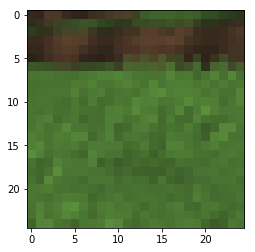

In [117]:
input_tensor = preprocess_image_for_model("images/terrain.png")
pred = hunter(input_tensor)
index, percentage = result_to_prob_dist_percentage(pred)
print ("Prediction = ", animals[index], percentage, "%" )

## Forward propagation with a manually set label
* The manually set label is the target label, i.e the label we want to convert the image into.
* In our case the target label is a `[0]` which refers to a chicken

In [118]:
loss = nn.CrossEntropyLoss()

label = torch.tensor([0], dtype=torch.long)  ## manually set the label to zero 
input_tensor.requires_grad = True  # gradients 
pred = hunter(input_tensor)
loss_val = loss(pred,label)
print("loss = ",loss_val.item())



loss =  11.767049789428711


## Backpropagation and the extraction of gradients from the input image for the "reverse" FGSM to be done
* It is kind of justified to call it a form of "reverse" FGSM because we are "optimizing" the image to minimise loss 
* But the key is that we're optimizing it to belong to a different class

In [119]:
loss_val.backward() #backprop
data_grad = input_tensor.grad.data
print(data_grad.size())

torch.Size([1, 3, 25, 25])


> Note: `torch.clamp()` makes sure that the pixels values which overshoot to a value over 255 after the perturbation are clamped down at a `[0:256]` range

In [120]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
        # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
        
    delta = epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 255)
    
    return perturbed_image, delta


## Making the model see a chicken where there's none
* Notice the use of a __negative epsilon__ on the `fgsm_attack()`
* The weird image on the bottom might look like noise, but is actually the visualization of `epsilon*sign(data_grad)`

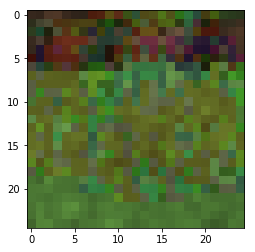

Prediction =  chicken 90.20503997802734 %


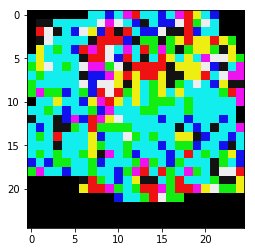

In [127]:
bamboozle_tensor , addition= fgsm_attack(input_tensor, -18, data_grad)
bamboozle_image = tensor_to_image(bamboozle_tensor)
addition = tensor_to_image(addition)

plt.imshow(bamboozle_image)
plt.show()

pred = hunter(bamboozle_tensor)
index, percentage = result_to_prob_dist_percentage(pred)
print ("Prediction = ", animals[index], percentage, "%" )

plt.imshow(addition)
plt.show()

In [253]:
def spawn_ghost_animal_with_visualisation(image_path, model, epsilon, target_label):
    
    loss = nn.CrossEntropyLoss()
    
    input_tensor = preprocess_image_for_model(image_path)
    input_tensor.requires_grad = True  # gradients 
    label = torch.tensor([target_label], dtype=torch.long)  
    pred = model(input_tensor)
    loss_val = loss(pred,label)
    loss_val.backward() #backprop
    data_grad = input_tensor.grad.data
    bamboozle_tensor , addition= fgsm_attack(input_tensor, epsilon, data_grad)
    bamboozle_image = tensor_to_image(bamboozle_tensor)
    addition = tensor_to_image(addition)
    predict = model(bamboozle_tensor)
    index, perc = result_to_prob_dist_percentage(predict)
#     print ("Prediction = ", animals[index], perc, "%" )
    
    result = [animals[index], perc]

    return bamboozle_image, result , addition

In [254]:
images = []
results = []
deltas = []
for m in range (1,3):
    
    image, res, delta = spawn_ghost_animal_with_visualisation("images/chicken.png", hunter, -7, m)
    images.append(image)
    results.append(res)
    deltas.append(delta)


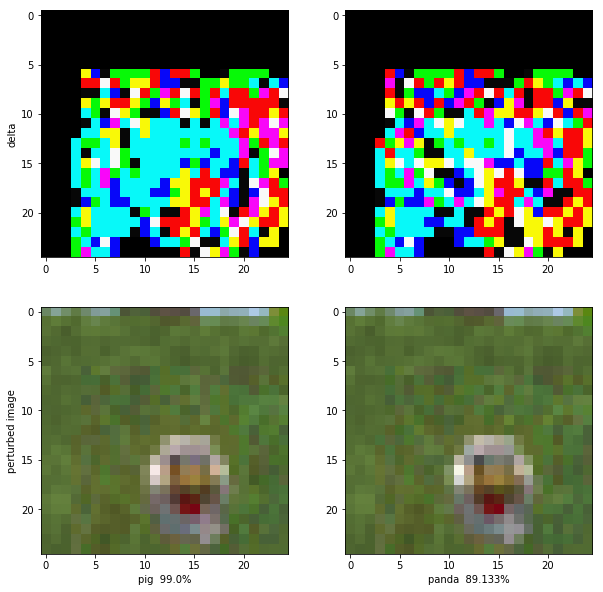

In [276]:
plt.rcParams["figure.figsize"] = (10,10)
fig, axs = plt.subplots(2,2)
axs.flat[0].set(ylabel= "delta")
axs.flat[2].set(ylabel= "perturbed image")


for i in range(0, 2):
    axs[0,i].imshow(deltas[i])
    axs[1,i].imshow(images[i])
    axs[1,i].set(xlabel = results[i][0] + "  "+ str(round(results[i][1],3)) + "%")
